In [2]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from io import StringIO
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [3]:
fetcher = DataFetcher(DB_PARAMS)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:132: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:107: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [4]:
df = fetcher.fetch_data(
    regressors=[
    'hv_orig_score', 
    "md_hv1", 
    "md_hv2", 
    'md_hv3', 
    'lm_orig_score', 
    'md_lm1', 
    'md_lm2', 
    'md_lm3',
    'eps_surprise',
    'f_size',
    'doc_len'
    
    ],
    prepare_fixed_effects=True,
    )

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:164: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:211: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:226: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBA

In [5]:
df.loc[('ZTS', 2022.4)]


report_type                      10-Q
hv_orig_score                0.470539
md_hv1                       0.402945
md_hv2                       0.427981
md_hv3                       0.108857
lm_orig_score               -0.682203
md_lm1                       -0.05434
md_lm2                      -0.288221
md_lm3                       -0.56778
eps_surprise                    -2.07
f_size             62299844239.999992
doc_len                        176716
two_day_r                    0.011175
three_day_r                   0.84234
four_day_r                   0.333581
five_day_r                   0.621692
six_day_r                    1.139272
seven_day_r                  1.581386
full_q_r                     0.428868
two_day_e_r                 -0.624464
three_day_e_r                0.094377
four_day_e_r                -0.186676
five_day_e_r                -0.056751
six_day_e_r                  0.110365
seven_day_e_r                0.644936
full_q_e_r                   0.276128
two_day_abn_

In [6]:
class FEModeler:
    """
    A class to run panel fixed effects regressions using PanelOLS
    and extract key parameter statistics for a specified regressor.

    Attributes:
        df: The input panel data.
        var_names: Column names of the input DataFrame.
        params_dict: Dictionary storing regression parameters for each independent variable.
    """

    def __init__(self, df: pd.DataFrame, scale: bool = False):
        """
        Initialize the FEModeler with panel data.

        Args:
            df: Panel DataFrame with MultiIndex (entity, time).
            scale: Whether to standardize the regressors.
        """
        self.original_df = df.copy()
        self.df = df.copy()
        self.var_names = df.columns
        self.params_dict = {}
        self.scale = scale

        if scale:
            self._scale_regressors()

    def _scale_regressors(self):
        """
        Standardize regressors: columns 1 to 8 (your x variables), plus control variables eps_surprise, f_size.
        Scaling is done entity-wise (within-entity).
        """
        x_cols = list(self.df.columns[1:9]) + ['eps_surprise', 'f_size']
        scaler = StandardScaler()

        # Scale within each entity group
        for entity in self.df.index.get_level_values(0).unique():
            entity_mask = self.df.index.get_level_values(0) == entity
            sub_df = self.df.loc[entity_mask, x_cols]
            if sub_df.shape[0] < 2:
                continue
            self.df.loc[entity_mask, x_cols] = scaler.fit_transform(sub_df)


    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        """
        Extract parameter statistics for a given regressor from the regression summary.

        Args:
            summary: The PanelOLS regression summary object.
            regressor_name: The name of the regressor to extract parameters for.

        Returns:
            A Series containing coefficient, std error, p-value, and confidence intervals.
        """
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        """
        Fit a fixed effects regression model using PanelOLS.

        Args:
            data: A subset of the full DataFrame containing required variables.
            formula: Regression formula in Patsy-style syntax.

        Returns:
            The regression summary object.
        """
        model = PanelOLS.from_formula(formula, data=data, check_rank=True)
        result = model.fit(cov_type='kernel')
        return result.summary

    def compute(self) -> dict[str, list[pd.Series]]:
        """
        Run fixed effects regressions for all combinations of independent and dependent variables,
        and store the parameter summaries for each independent variable.

        Returns:
            A dictionary where keys are independent variable names,
            and values are lists of Series with parameter info for each dependent variable.
        """
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter' ]

        var_names = self.df.columns 

        for x in range(1, 9):
            # Targets starts from y index
            y = 12

            per_target_params = {}
            for target in targets:  
                if target not in per_target_params:
                    per_target_params[target] = {}

                for frame in time_frames:
                    print(self.df.columns[x], self.df.columns[y])

                    data = self.df.iloc[:, [x, 9, 10, 11, y]].dropna().copy()
                    print(data)
                    formula = f"{var_names[y]} ~ {var_names[x]}  + f_size + EntityEffects + TimeEffects"
                    try:
                        result_summary = self.fit(data, formula)
                        print(result_summary)
                        param_info = self.extract_params(result_summary, self.var_names[x])
                        per_target_params[target][self.df.columns[y]] = param_info
                        
                    except Exception as e:
                        print(e)
                    y += 1

            self.params_dict[self.df.columns[x]] = per_target_params

        return self.params_dict
    
    def plot_all_params(self):
        """
        Plot bar charts for each regressor–target combination.
        Each chart shows 7 timeframes with confidence intervals.
        """
        for regressor, target_dict in self.params_dict.items():
            for target, outcomes in target_dict.items():
                keys = list(outcomes.keys())
                if len(keys) < 1:
                    continue

                x = np.arange(len(keys))
                params = [outcomes[k]['Parameter'] for k in keys]
                lower = [outcomes[k]['Lower CI'] for k in keys]
                upper = [outcomes[k]['Upper CI'] for k in keys]

                plt.figure(figsize=(8, 6))
                plt.bar(x, params, width=0.4, color='tab:blue', label=regressor)

                # Confidence intervals
                for i in range(len(keys)):
                    plt.plot([x[i], x[i]], [lower[i], upper[i]], color='black', linewidth=1.5)

                plt.axhline(0, color='black', linewidth=1)
                plt.xticks(x, keys, rotation=45)
                plt.title(f"{regressor} on {target}")
                plt.xlabel('Time frame')
                plt.ylabel('Beta coefficient')
                plt.tight_layout()

                ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')
                plt.legend(handles=[ci_legend])
                plt.show()


In [7]:
df.isna().sum()

report_type            0
hv_orig_score          0
md_hv1                 0
md_hv2                 0
md_hv3                 0
lm_orig_score          0
md_lm1                 0
md_lm2                 0
md_lm3                 0
eps_surprise          86
f_size                 0
doc_len                0
two_day_r              0
three_day_r            0
four_day_r             0
five_day_r             0
six_day_r              0
seven_day_r            0
full_q_r             360
two_day_e_r            0
three_day_e_r          0
four_day_e_r           0
five_day_e_r           0
six_day_e_r            0
seven_day_e_r          0
full_q_e_r           360
two_day_abn_r          0
three_day_abn_r        0
four_day_abn_r         0
five_day_abn_r         0
six_day_abn_r          0
seven_day_abn_r        0
full_q_abn_r         360
two_day_r_vol      12701
three_day_r_vol    12701
four_day_r_vol     12701
five_day_r_vol     12701
six_day_r_vol      12701
seven_day_r_vol    12701
full_q_r_vol       12702


In [8]:
df

report_type  hv_orig_score    md_hv1    md_hv2    md_hv3  \
company date                                                              
A       2018.1        10-Q       0.282086  0.389517  0.471162  0.138873   
        2018.2        10-Q       0.283859  0.391879  0.481426  0.121899   
        2018.3        10-Q       0.289956  0.387794  0.483189  0.114439   
        2018.4        10-K       0.402656  0.407274  0.467143  0.127188   
        2019.1        10-Q       0.295541  0.412048  0.463092  0.144105   
...                    ...            ...       ...       ...       ...   
ZTS     2023.3        10-Q       0.540293  0.421887  0.422424  0.093604   
        2023.4        10-Q       0.555752  0.419307  0.424917  0.090220   
        2024.1        10-K       0.445931  0.390678  0.464941  0.141537   
        2024.2        10-Q       0.511918  0.412575  0.424534  0.099913   
        2024.3        10-Q       0.532888  0.409023  0.423120  0.092551   

                lm_orig_score    md_lm1    md_lm2    md_lm3  eps_surprise  \
company date                                                                
A       2018.1      -0.399408 -0.028402 -0.469027 -0.715827         13.79   
        2018.2      -0.418994 -0.039749 -0.450777 -0.713576          1.19   
        2018.3      -0.405858 -0.044361 -0.456012 -0.701092          6.81   
        2018.4      -0.422794  0.058824 -0.441474 -0.664823         10.07   
        2019.1      -0.468391 -0.025729 -0.449024 -0.641541          4.02   
...                       ...       ...       ...       ...           ...   
ZTS     2023.3      -0.495495 -0.054323 -0.331487 -0.565027          7.19   
        2023.4      -0.520231 -0.044053 -0.306569 -0.551020          0.08   
        2024.1      -0.543266  0.024427 -0.392147 -0.600982         -6.01   
        2024.2      -0.602649 -0.016791 -0.321160 -0.534759          3.30   
        2024.3      -0.590296 -0.051245 -0.333333 -0.520170          4.95   

                ...  six_day_abn_r  seven_day_abn_r  full_q_abn_r  \
company date    ...                                                 
A       2018.1  ...       0.197947         0.251471     -0.166246   
        2018.2  ...       0.398708         0.405132      0.006692   
        2018.3  ...       0.338689         0.193875      0.186313   
        2018.4  ...       0.140298        -0.220145      0.121892   
        2019.1  ...      -0.083671         0.018716     -0.275623   
...             ...            ...              ...           ...   
ZTS     2023.3  ...       0.672010         0.452909     -0.121333   
        2023.4  ...       1.072089         0.904586      0.088919   
        2024.1  ...      -0.175947        -0.121877     -0.276364   
        2024.2  ...       0.416259         0.271954      0.179312   
        2024.3  ...      -0.066902        -0.225645     -0.150549   

                two_day_r_vol  three_day_r_vol  four_day_r_vol  \
company date                                                     
A       2018.1            NaN              NaN             NaN   
        2018.2            NaN              NaN             NaN   
        2018.3            NaN              NaN             NaN   
        2018.4            NaN              NaN             NaN   
        2019.1            NaN              NaN             NaN   
...                       ...              ...             ...   
ZTS     2023.3            NaN              NaN             NaN   
        2023.4            NaN              NaN             NaN   
        2024.1            NaN              NaN             NaN   
        2024.2            NaN              NaN             NaN   
        2024.3            NaN              NaN             NaN   

                five_day_r_vol  six_day_r_vol  seven_day_r_vol  full_q_r_vol  
company date                                                                  
A       2018.1             NaN            NaN              NaN          None  
        2018.2             NaN            N

In [9]:
df['eps_surprise']

company  date  
A        2018.1    13.79
         2018.2     1.19
         2018.3     6.81
         2018.4    10.07
         2019.1     4.02
                   ...  
ZTS      2023.3     7.19
         2023.4     0.08
         2024.1    -6.01
         2024.2     3.30
         2024.3     4.95
Name: eps_surprise, Length: 12702, dtype: float64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12702 entries, ('A', 2018.1) to ('ZTS', 2024.3)
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   report_type      12702 non-null  object 
 1   hv_orig_score    12702 non-null  float64
 2   md_hv1           12702 non-null  float64
 3   md_hv2           12702 non-null  float64
 4   md_hv3           12702 non-null  float64
 5   lm_orig_score    12702 non-null  float64
 6   md_lm1           12702 non-null  float64
 7   md_lm2           12702 non-null  float64
 8   md_lm3           12702 non-null  float64
 9   eps_surprise     12616 non-null  float64
 10  f_size           12702 non-null  float64
 11  doc_len          12702 non-null  int64  
 12  two_day_r        12702 non-null  float64
 13  three_day_r      12702 non-null  float64
 14  four_day_r       12702 non-null  float64
 15  five_day_r       12702 non-null  float64
 16  six_day_r        12702 non-null  flo

In [11]:
model = FEModeler(df=df, scale=False)
res = model.compute()

hv_orig_score two_day_r
                hv_orig_score  eps_surprise        f_size  doc_len  two_day_r
company date                                                                 
A       2018.1       0.282086         13.79  2.221827e+10   189840   1.431105
        2018.2       0.283859          1.19  2.001238e+10   211900   0.415003
        2018.3       0.289956          6.81  2.152972e+10   212879   0.253735
        2018.4       0.402656         10.07  2.017495e+10   414931  -2.562945
        2019.1       0.295541          4.02  2.500438e+10   206555  -0.831038
...                       ...           ...           ...      ...        ...
ZTS     2023.3       0.540293          7.19  8.716102e+10   159761   2.154832
        2023.4       0.555752          0.08  7.448206e+10   163165   4.819385
        2024.1       0.445931         -6.01  8.451370e+10   472537  -0.734195
        2024.2       0.511918          3.30  7.623317e+10   134602   1.302875
        2024.3       0.532888          4

                hv_orig_score  eps_surprise        f_size  doc_len  five_day_r
company date                                                                  
A       2018.1       0.282086         13.79  2.221827e+10   189840    0.950135
        2018.2       0.283859          1.19  2.001238e+10   211900    0.881082
        2018.3       0.289956          6.81  2.152972e+10   212879    0.044782
        2018.4       0.402656         10.07  2.017495e+10   414931    0.245934
        2019.1       0.295541          4.02  2.500438e+10   206555   -0.109973
...                       ...           ...           ...      ...         ...
ZTS     2023.3       0.540293          7.19  8.716102e+10   159761    0.768598
        2023.4       0.555752          0.08  7.448206e+10   163165    2.016615
        2024.1       0.445931         -6.01  8.451370e+10   472537    0.006431
        2024.2       0.511918          3.30  7.623317e+10   134602    0.331083
        2024.3       0.532888          4.95  8.43096

In [12]:
for key in res:
    print(key, '\n', res[key], '\n\n\n')

hv_orig_score 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_hv1 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_hv2 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_hv3 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



lm_orig_score 
 {'returns': {'full_q_r': Parameter   -0.1403
std_err      0.0130
P-value      0.0000
Lower CI    -0.1659
Upper CI    -0.1148
Name: lm_orig_score, dtype: float64}, 'e_returns': {'full_q_e_r': Parameter   -0.0528
std_err      0.0118
P-value      0.0000
Lower CI    -0.0760
Upper CI    -0.0296
Name: lm_orig_score, dtype: float64}, 'abn_returns': {'full_q_abn_r': Parameter   -0.0185
std_err      0.0066
P-value      0.0051
Lower CI    -0.0314
Upper CI    -0.0055
Name: lm_orig_score, dtype: float64}, 'r_vol': {}} 



md_lm1 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_lm2 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {

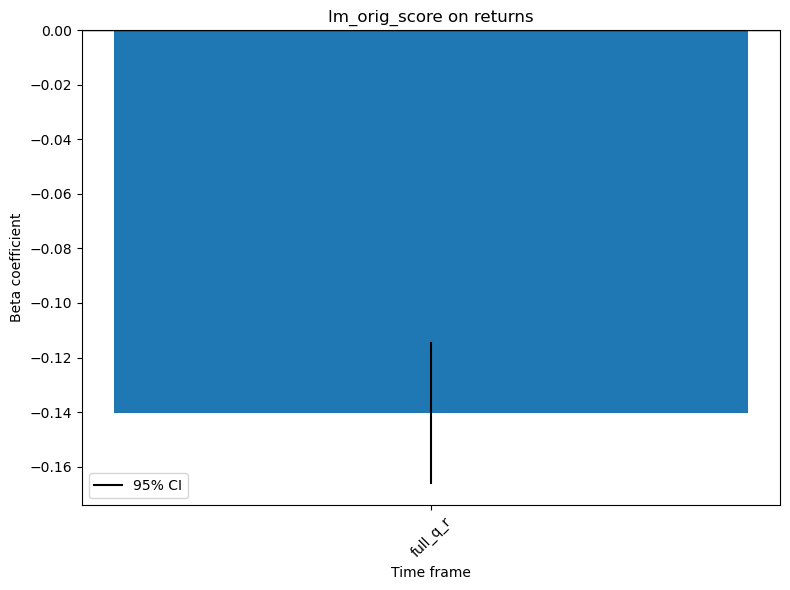

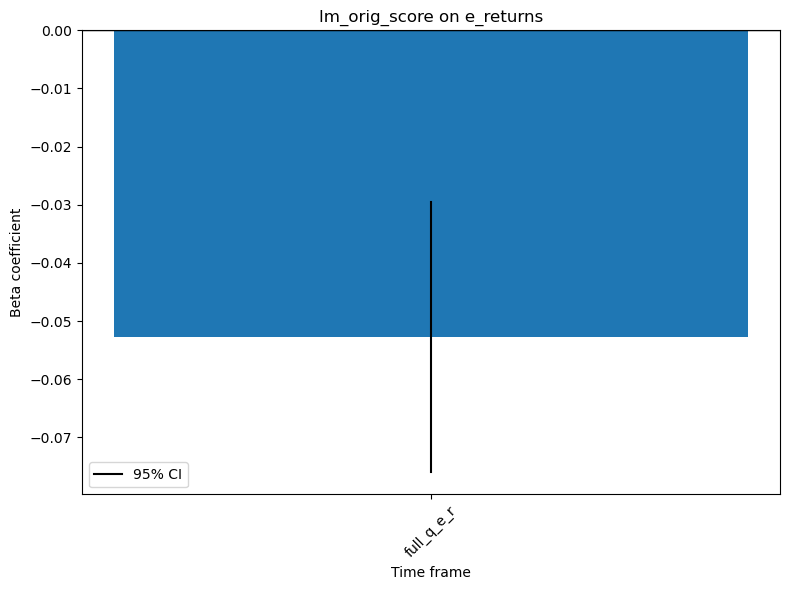

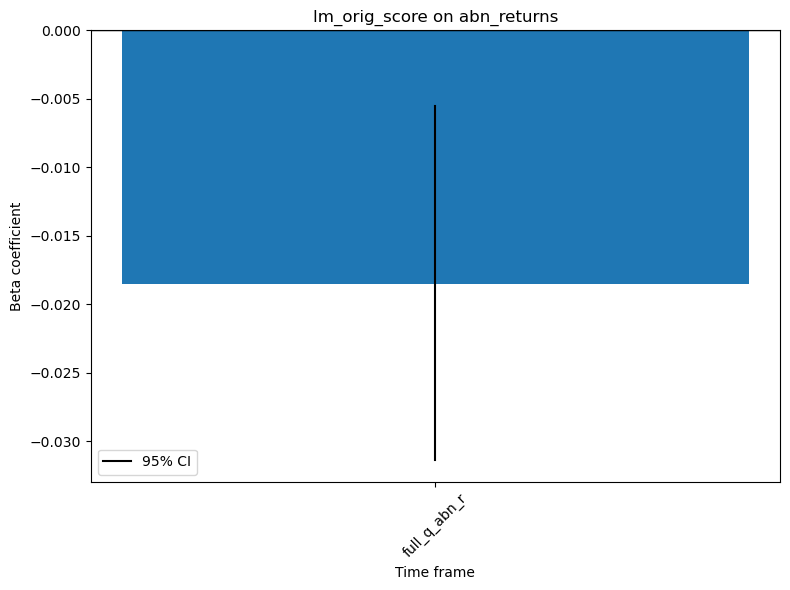

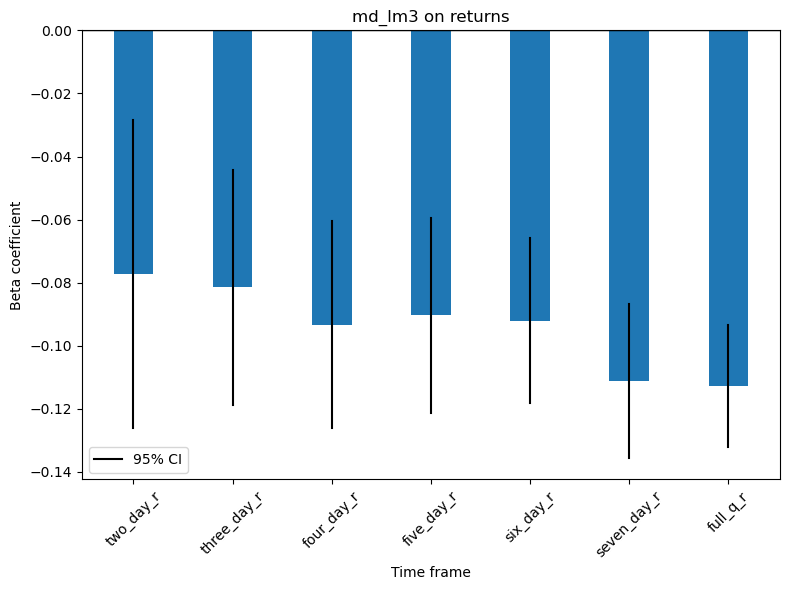

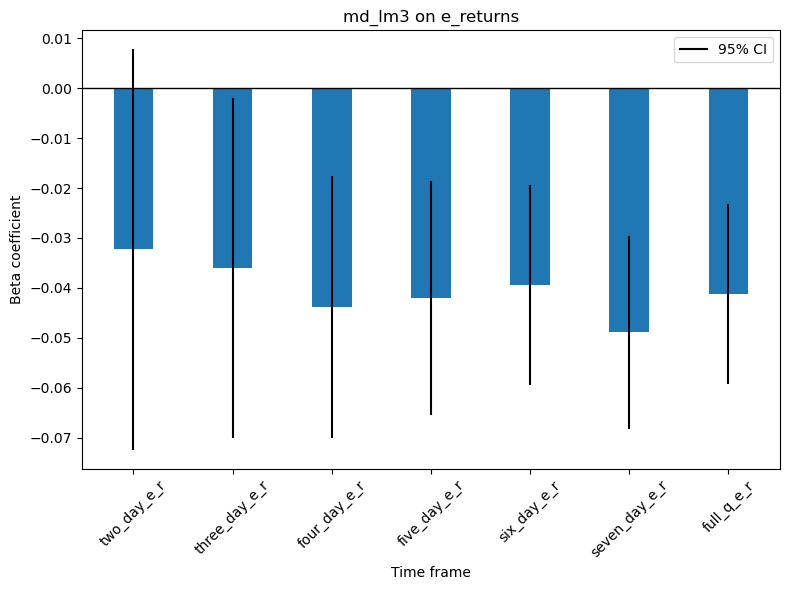

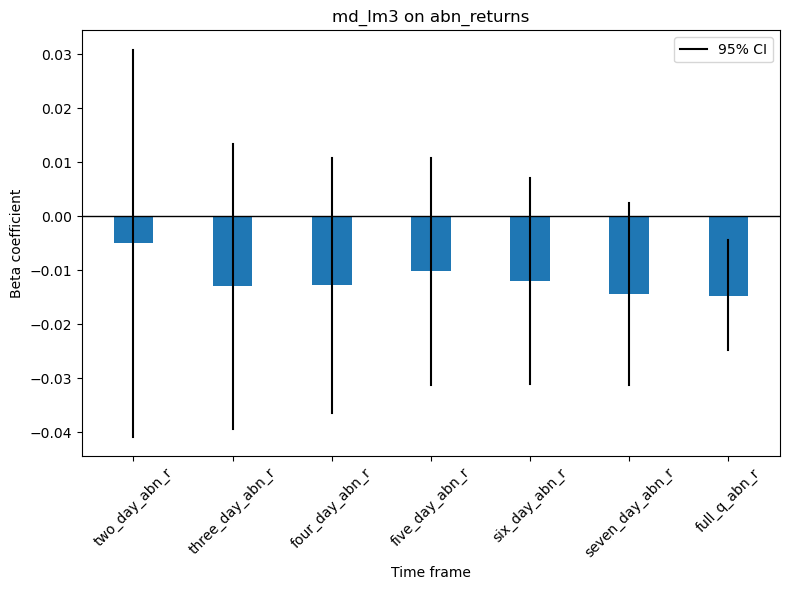

In [13]:
model.plot_all_params()